In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
# import seaborn as sns
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
# import arrow
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
weekly_df = weekly_df.iloc[209:]

In [3]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$\log cases = \log pop. + \log\,\theta(w\cdot x) \,+\, ...$$

In [117]:
from scipy.special import expit
from scipy.optimize import fmin, minimize

LAG = 26
BETAS_SET = LAG + 1
train = weekly_df.cases[:104]

def theta(w,x):
    pad_x = np.concatenate(([1],np.array(x)))
    score = np.dot(w,pad_x)
    return expit(score)

def guess(w,x):
    return np.log(theta(w,x)+ 1e-5) + np.log(7500.)

def cost(w):
#     return sum((train[i+11] - guess(w,train[i:i+10]))**2 \
#                for i in range(len(train)-11))/len(train)
    ret = 0
    for i in range(len(train)-BETAS_SET):
        real_case = np.log(train[i+BETAS_SET])
        predicted_case = guess(w,train[i:i+LAG])
        ret += (real_case - predicted_case)**2
    print ret/float(len(train))
    return ret/float(len(train))

arr = [0]*BETAS_SET
w = minimize(cost,arr)


0.920115888725
0.920115899587
0.920133071293
0.92013349904
0.920133990144
0.920134233487
0.920134434075
0.920134664466
0.920134811525
0.920134872693
0.920134941487
0.920134976241
0.920134826107
0.920134766896
0.920134508341
0.920134153587
0.920133665018
0.920133506494
0.920133188077
0.920132817734
0.92013249789
0.920132203426
0.920131848314
0.920131442428
0.920130972349
0.920130385311
0.92012988357
0.920129517233
0.920115888725
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.82136

In [118]:
w.x

array([ -2.22229202e+00,  -3.52210243e-05,   6.22295763e-05,
        -1.89998518e-04,   1.00279485e-05,  -1.14047941e-04,
        -5.58356227e-05,   6.00101545e-05,   8.46576043e-06,
         1.29237302e-04,   1.28064008e-04,  -8.86658439e-05,
        -1.02393602e-04,  -1.74570287e-04,   2.14928196e-04,
         2.24767381e-04,  -3.45688259e-04,  -9.29992758e-05,
         1.48169862e-04,   2.32432377e-04,  -6.03834485e-05,
        -2.09187331e-04,  -8.97466123e-05,  -2.39505436e-04,
         1.33731655e-04,   3.63256437e-04,   5.40239563e-04])

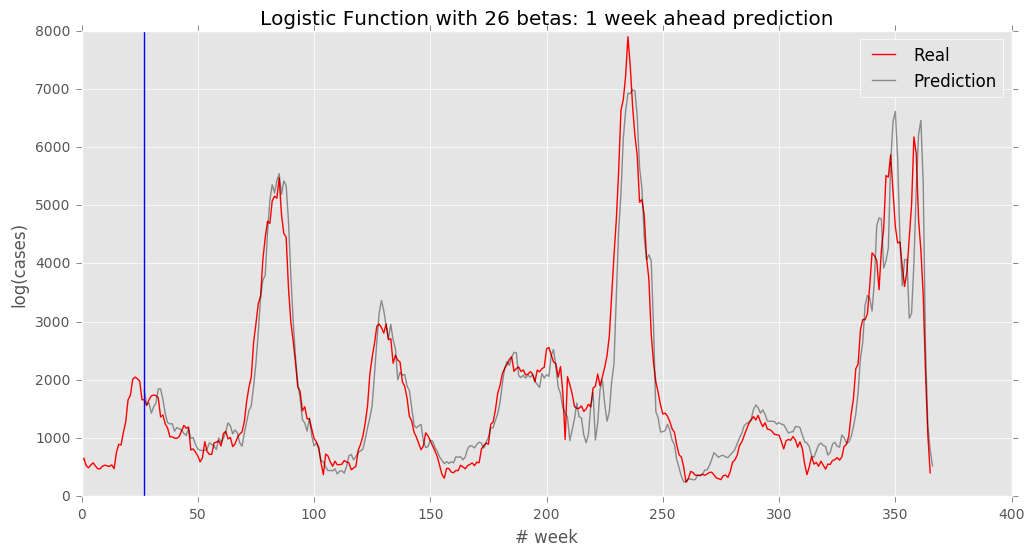

In [125]:
NWEEKS = 26
ls_ = []
# 2007 onward
test = weekly_df.cases[104:]
for i in range(len(test)-NWEEKS):
    res = np.exp(guess(w.x,test[i:i+NWEEKS]))
    ls_.append(res)
    
make_line(27,test,ls_,
          'Logistic Function with 26 betas: 1 week ahead prediction',
          "# week","log(cases)")

In [ ]:
NWEEKS = 26
ls_ = []
# 2007 onward
test = weekly_df.cases[104:]
for i in range(len(test)-NWEEKS):
    first_prediction = np.exp(guess(w.x,test[i:i+NWEEKS]))
    ls_.append(res)
    
make_line(27,test,ls_,
          'Logistic Function with 26 betas: 1 week ahead prediction',
          "# week","log(cases)")

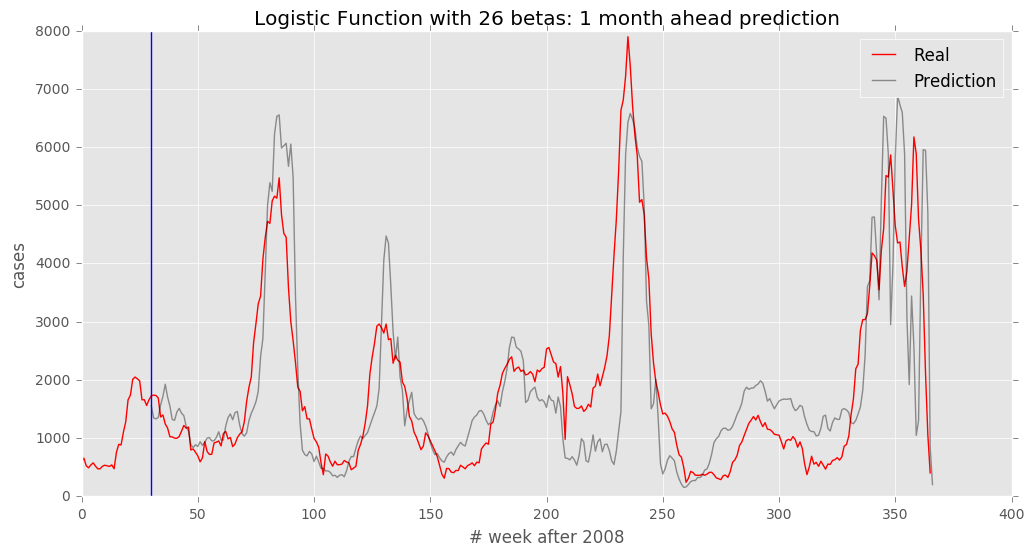

In [170]:
prediction_4week = []
test = np.array(weekly_df.cases[104:])
for i in range(len(test)-(NWEEKS+3)):
    
    first_prediction = np.exp(guess(w.x,test[i:i+NWEEKS]))
    first_arr = np.append(test[i+1:i+(NWEEKS)],first_prediction)
    
    second_prediction = np.exp(guess(w.x,first_arr))
    second_arr = np.append(first_arr[1:],second_prediction)
    
    third_prediction = np.exp(guess(w.x,second_arr))
    third_arr = np.append(second_arr[1:],third_prediction)
    
    res = np.exp(guess(w.x,third_arr))
    prediction_4week.append(res)
    
make_line(30,test,prediction_4week,
          'Logistic Function with 26 betas: 1 month ahead prediction',
          "# week after 2008","cases")

In [209]:
a = [str(i) for i in range(20)]

def calc(arr):
    st = ""
    for i in range(len(arr)):
        st += arr[i]
    return st[-3]

for i in range(len(a)-5):
    fst = calc(a[i:i+4])
    a1 = np.append(a[i:i+4],fst)
    print a1
    scn = calc(a1[1:])
    a2 = np.append(a1[1:],scn)
    print a2
    thd = calc(a2[1:])
    a3 = np.append(a2[1:],thd)
    print a3
    break

['0' '1' '2' '3' '1']
['1' '2' '3' '1' '2']
['2' '3' '1' '2' '3']


In [205]:
k = ['0', '1', '2', '3', '0123']
calc(k)

'1'

'01234'